<a href="https://colab.research.google.com/github/nitish-m/Market-Segmentation-Analysis-on-McDonalds-Data/blob/main/Market%20Segmentation%20Analysis%20on%20McDonalds%20Data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [71]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import LabelEncoder
from mpl_toolkits.mplot3d import Axes3D
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.utils import resample
from sklearn.metrics import adjusted_rand_score
from sklearn.mixture import GaussianMixture
from sklearn.utils import resample
from scipy.cluster.hierarchy import dendrogram, linkage
from scipy.spatial.distance import pdist
from statsmodels.graphics.mosaicplot import mosaic
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import plot_tree

## Step 4: Exploring Data

In [23]:
mcdonalds = pd.read_csv("/content/mcdonalds.csv")

print(list(mcdonalds.columns))
print(mcdonalds.shape)
print(mcdonalds.head(3))

['yummy', 'convenient', 'spicy', 'fattening', 'greasy', 'fast', 'cheap', 'tasty', 'expensive', 'healthy', 'disgusting', 'Like', 'Age', 'VisitFrequency', 'Gender']
(1453, 15)
  yummy convenient spicy fattening greasy fast cheap tasty expensive healthy  \
0    No        Yes    No       Yes     No  Yes   Yes    No       Yes      No   
1   Yes        Yes    No       Yes    Yes  Yes   Yes   Yes       Yes      No   
2    No        Yes   Yes       Yes    Yes  Yes    No   Yes       Yes     Yes   

  disgusting Like  Age      VisitFrequency  Gender  
0         No   -3   61  Every three months  Female  
1         No   +2   51  Every three months  Female  
2         No   +1   62  Every three months  Female  


In [35]:
MD_x = mcdonalds.iloc[:, 0:11].values
MD_x = (MD_x == "Yes").astype(int)
col_means = np.round(np.mean(MD_x, axis=0), 2)
print(col_means)

[0.55 0.91 0.09 0.87 0.53 0.9  0.6  0.64 0.36 0.2  0.24]
[[0 1 0 ... 1 0 0]
 [1 1 0 ... 1 0 0]
 [0 1 1 ... 1 1 0]
 ...
 [1 1 0 ... 1 0 0]
 [1 1 0 ... 0 1 0]
 [0 1 0 ... 1 0 1]]


In [25]:
pca = PCA()
MD_pca = pca.fit_transform(MD_x)

print(pca.explained_variance_ratio_)
print(pca.singular_values_)

[0.29944723 0.19279721 0.13304535 0.08309578 0.05948052 0.05029956
 0.0438491  0.03954779 0.0367609  0.03235329 0.02932326]
[28.84746118 23.14716582 19.22858381 15.19626736 12.85685762 11.82305052
 11.03895052 10.48355462 10.10742431  9.48214684  9.02721076]


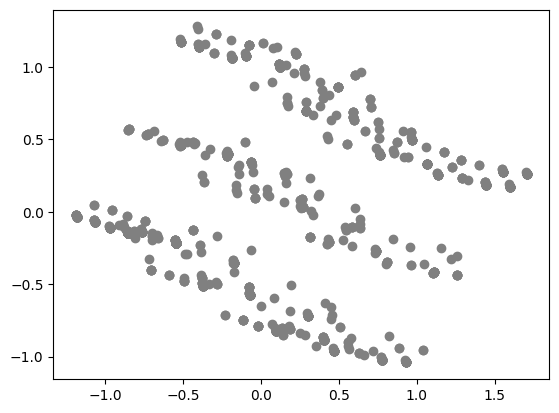

In [26]:
plt.scatter(MD_pca[:, 0], MD_pca[:, 1], color="grey")
plt.show()

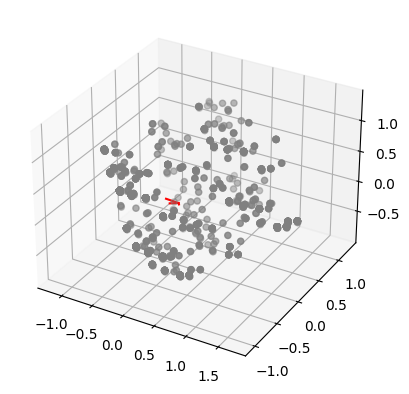

In [27]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(MD_pca[:, 0], MD_pca[:, 1], MD_pca[:, 2], c='grey')

origin = np.zeros((3,))
axes = pca.components_[:3, :].T
ax.plot([origin[0], axes[0, 0]], [origin[1], axes[0, 1]], [origin[2], axes[0, 2]], color='r')
ax.plot([origin[0], axes[1, 0]], [origin[1], axes[1, 1]], [origin[2], axes[1, 2]], color='r')
ax.plot([origin[0], axes[2, 0]], [origin[1], axes[2, 1]], [origin[2], axes[2, 2]], color='r')

plt.show()

## Step 5: Extracting Segments

In [28]:
np.random.seed(1234)

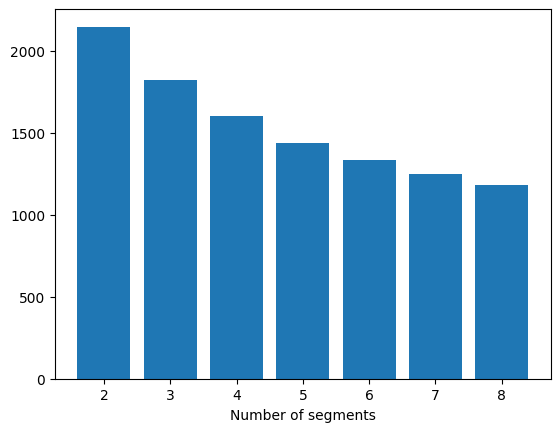

In [29]:
n_clusters_range = range(2, 9)
inertia_values = []
for n_clusters in n_clusters_range:
    kmeans = KMeans(n_clusters=n_clusters, n_init=10, random_state=1234)
    kmeans.fit(MD_x)
    inertia_values.append(kmeans.inertia_)

best_n_clusters = np.argmin(inertia_values) + 2
kmeans = KMeans(n_clusters=best_n_clusters, n_init=10, random_state=1234)
kmeans.fit(MD_x)
labels = kmeans.labels_

plt.bar(n_clusters_range, inertia_values)
plt.xlabel("Number of segments")
plt.show()

In [30]:
np.random.seed(1234)

k_range = range(2, 9)
n_rep = 10
flexmix_results = []
aic_scores = []
bic_scores = []
icl_scores = []

for k in k_range:
    flexmix_cluster_indices = []
    aic_rep_scores = []
    bic_rep_scores = []
    icl_rep_scores = []
    for _ in range(n_rep):
        resampled_indices = resample(range(len(MD_x)), n_samples=len(MD_x), replace=True, random_state=1234)
        flexmix = GaussianMixture(n_components=k, random_state=1234)
        flexmix.fit(MD_x[resampled_indices])
        flexmix_cluster_indices.append(flexmix.predict(MD_x))
        aic_rep_scores.append(flexmix.aic(MD_x))
        bic_rep_scores.append(flexmix.bic(MD_x))
        icl_rep_scores.append(flexmix.score(MD_x))

    aic_scores.append(aic_rep_scores)
    bic_scores.append(bic_rep_scores)
    icl_scores.append(icl_rep_scores)
    flexmix_results.append(flexmix_cluster_indices)

for k, results in zip(k_range, flexmix_results):
    print(f"Number of segments (k = {k}):")
    for rep, cluster_indices in enumerate(results):
        print(f"  Repetition {rep + 1}: {cluster_indices}")
    print()

Number of segments (k = 2):
  Repetition 1: [0 0 0 ... 0 0 1]
  Repetition 2: [0 0 0 ... 0 0 1]
  Repetition 3: [0 0 0 ... 0 0 1]
  Repetition 4: [0 0 0 ... 0 0 1]
  Repetition 5: [0 0 0 ... 0 0 1]
  Repetition 6: [0 0 0 ... 0 0 1]
  Repetition 7: [0 0 0 ... 0 0 1]
  Repetition 8: [0 0 0 ... 0 0 1]
  Repetition 9: [0 0 0 ... 0 0 1]
  Repetition 10: [0 0 0 ... 0 0 1]

Number of segments (k = 3):
  Repetition 1: [2 2 2 ... 2 0 1]
  Repetition 2: [2 2 2 ... 2 0 1]
  Repetition 3: [2 2 2 ... 2 0 1]
  Repetition 4: [2 2 2 ... 2 0 1]
  Repetition 5: [2 2 2 ... 2 0 1]
  Repetition 6: [2 2 2 ... 2 0 1]
  Repetition 7: [2 2 2 ... 2 0 1]
  Repetition 8: [2 2 2 ... 2 0 1]
  Repetition 9: [2 2 2 ... 2 0 1]
  Repetition 10: [2 2 2 ... 2 0 1]

Number of segments (k = 4):
  Repetition 1: [3 2 2 ... 3 3 2]
  Repetition 2: [3 2 2 ... 3 3 2]
  Repetition 3: [3 2 2 ... 3 3 2]
  Repetition 4: [3 2 2 ... 3 3 2]
  Repetition 5: [3 2 2 ... 3 3 2]
  Repetition 6: [3 2 2 ... 3 3 2]
  Repetition 7: [3 2 2 ... 3

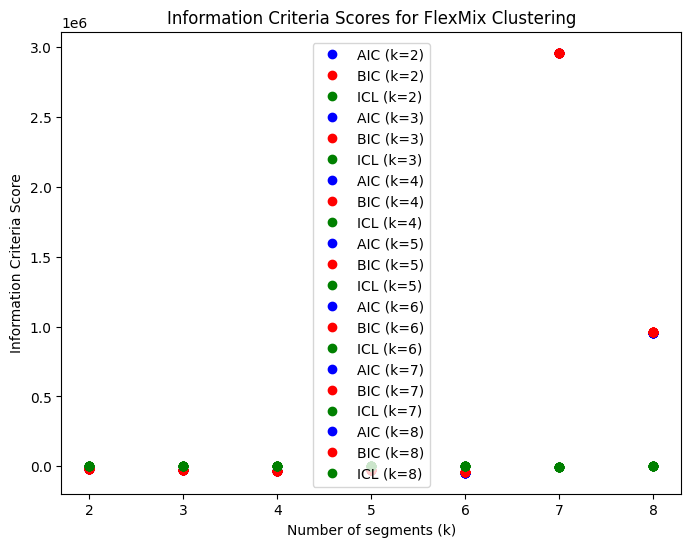

In [31]:
plt.figure(figsize=(8, 6))
for k, aic, bic, icl in zip(k_range, aic_scores, bic_scores, icl_scores):
    plt.plot([k] * n_rep, aic, 'bo', label=f"AIC (k={k})")
    plt.plot([k] * n_rep, bic, 'ro', label=f"BIC (k={k})")
    plt.plot([k] * n_rep, icl, 'go', label=f"ICL (k={k})")
plt.xlabel("Number of segments (k)")
plt.ylabel("Information Criteria Score")
plt.title("Information Criteria Scores for FlexMix Clustering")
plt.legend()
plt.show()

In [37]:
mcdonalds.Like.describe

<bound method NDFrame.describe of 0                 -3
1                 +2
2                 +1
3                 +4
4                 +2
            ...     
1448    I hate it!-5
1449              +2
1450              +3
1451              +4
1452              -3
Name: Like, Length: 1453, dtype: object>

In [39]:
mcdonalds.Like = mcdonalds.Like.str.replace('\D','',regex=True)
mcdonalds.Like.describe

<bound method NDFrame.describe of 0       3
1       2
2       1
3       4
4       2
       ..
1448    5
1449    2
1450    3
1451    4
1452    3
Name: Like, Length: 1453, dtype: object>

In [43]:
column_names = mcdonalds.columns[0:11]
for col in column_names:
    print(col,end ="  " )

yummy  convenient  spicy  fattening  greasy  fast  cheap  tasty  expensive  healthy  disgusting  

In [80]:
model = GaussianMixture(n_components=2, n_init=10, random_state=1234)
model.fit(MD_x)
print(model)

model_refit = GaussianMixture(n_components=2, n_init=1, random_state=1234)
model_refit.weights_ = model.weights_
model_refit.means_ = model.means_
model_refit.covariances_ = model.covariances_

print(model_refit)
print( model.covariances_)

GaussianMixture(n_components=2, n_init=10, random_state=1234)
GaussianMixture(n_components=2, random_state=1234)
[[[ 2.01563386e-01  3.52746731e-02  1.79569362e-02 -1.36834319e-02
   -2.05365622e-02 -3.50692161e-02  1.51672876e-02  1.45586785e-01
    4.57484110e-03  4.06074220e-02 -7.22432246e-02]
  [ 3.52746731e-02  2.04343903e-01  8.30046022e-03  2.16140697e-02
    8.07217472e-03  5.30535470e-03  2.62254365e-02  4.47896121e-02
   -2.25728687e-02  9.22273357e-03  1.51124990e-02]
  [ 1.79569362e-02  8.30046022e-03  8.69092840e-02  2.83530572e-03
    7.47863248e-03  6.28698224e-03  7.31426693e-03  1.82856673e-02
    5.01314925e-03  2.17784352e-02  1.08070349e-02]
  [-1.36834319e-02  2.16140697e-02  2.83530572e-03  8.69092840e-02
    5.02136752e-02  2.57642998e-02  9.77975017e-03 -1.18754109e-02
    7.80736358e-03 -1.53681788e-02  3.83382643e-02]
  [-2.05365622e-02  8.07217472e-03  7.47863248e-03  5.02136752e-02
    2.00618284e-01  3.35944919e-02  7.35992402e-03 -1.17521368e-02
    2.207

## Step 6 : Profiling Segments

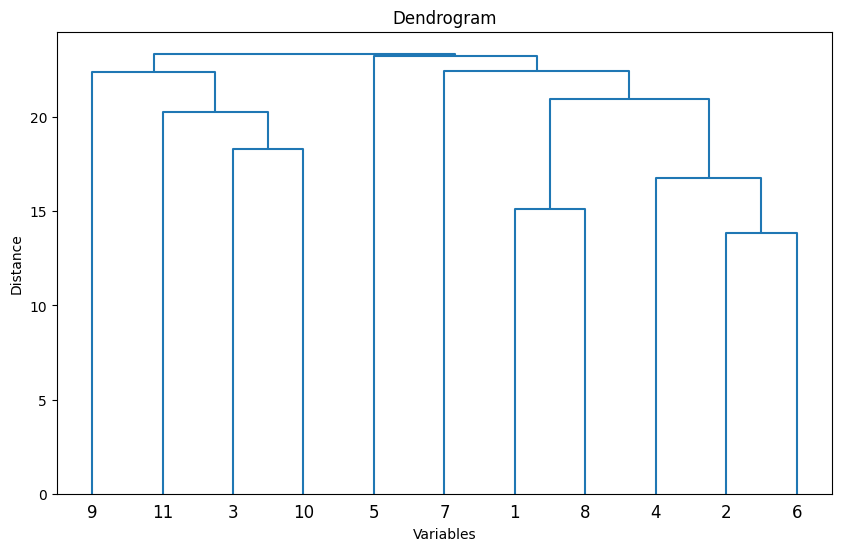

In [49]:
dist_matrix = pdist(MD_x.T)
linkage_matrix = linkage(dist_matrix)
plt.figure(figsize=(10, 6))
dendrogram(linkage_matrix, labels=range(1, MD_x.shape[1] + 1), orientation='top', color_threshold=0)
plt.title("Dendrogram")
plt.xlabel("Variables")
plt.ylabel("Distance")
plt.show()

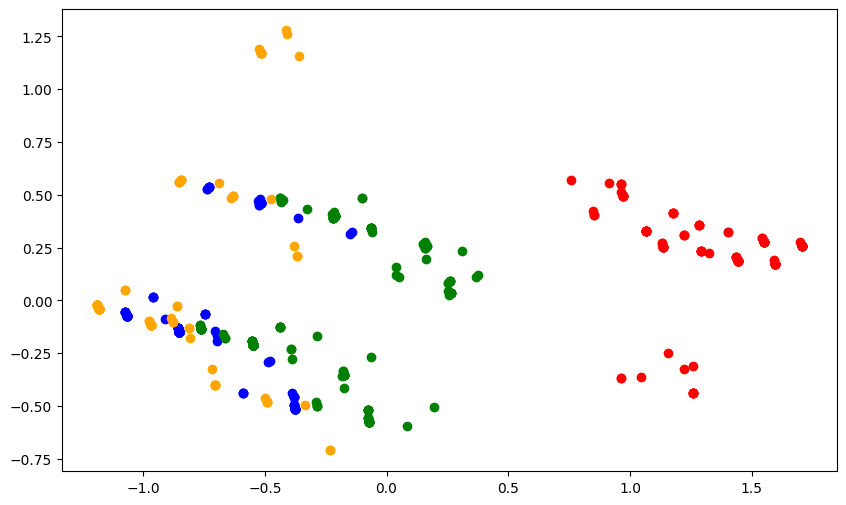

In [54]:
pca = PCA(n_components=2)
pca.fit(MD_x)
MD_pca_transformed = pca.transform(MD_x)

plt.figure(figsize=(10, 6))
colors = ['red', 'blue', 'green', 'orange']
for cluster, color in zip(np.unique(labels), colors):
    plt.scatter(MD_pca_transformed[labels == cluster, 0], MD_pca_transformed[labels == cluster, 1], color=color)

## Step 7: Describing Segments

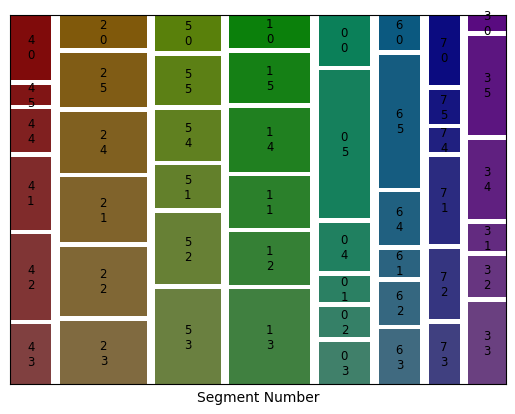

In [52]:
data = pd.DataFrame({'k4': labels, 'Like': mcdonalds['Like']})
mosaic(data, ['k4', 'Like'], gap=0.02, title='', axes_label=False)
plt.xlabel('Segment Number')
plt.show()

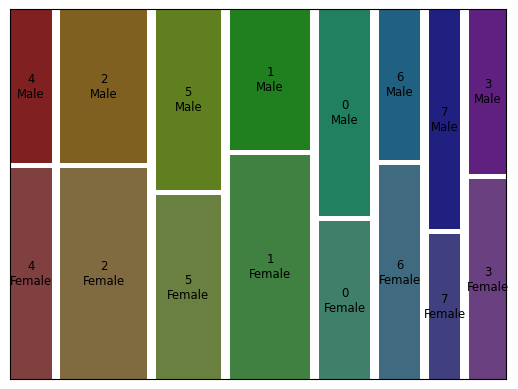

In [56]:
data = pd.DataFrame({'k4': labels, 'Gender': mcdonalds['Gender']})

mosaic(data, ['k4', 'Gender'], gap=0.02, title='', axes_label=False)

plt.show()

## Step 8: Selecting (the) Target Segment(s)

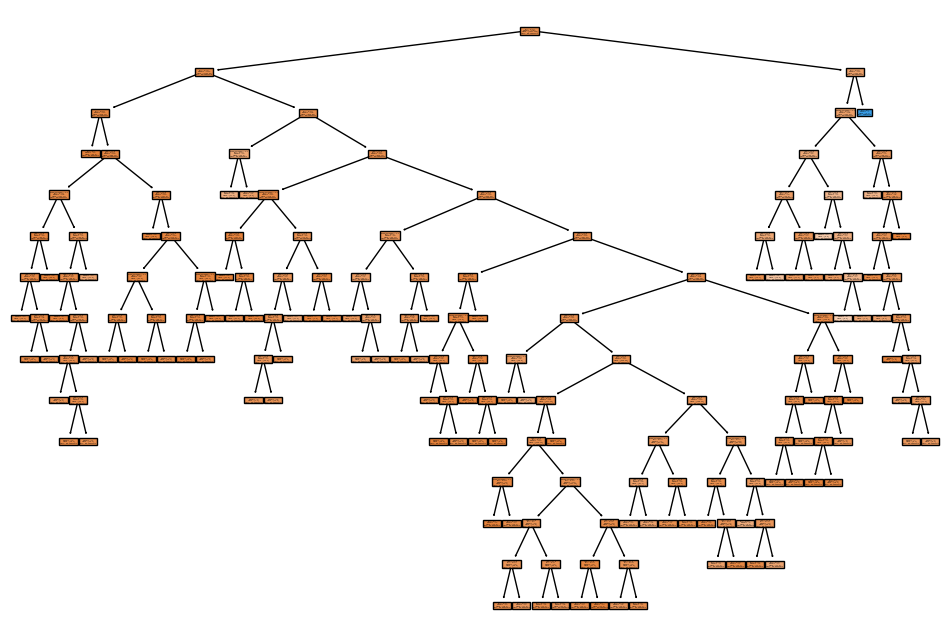

In [74]:
mcdonalds['Like'] = pd.to_numeric(mcdonalds['Like'], errors='coerce')
label_encoder = LabelEncoder()
mcdonalds['Gender_encoded'] = label_encoder.fit_transform(mcdonalds['Gender'])
X = mcdonalds[['Age', 'Gender_encoded']]
y = (labels == 3).astype(int)
tree = DecisionTreeClassifier()
tree.fit(X, y)
plt.figure(figsize=(12, 8))
plot_tree(tree, feature_names=X.columns, class_names=['Not Segment 3', 'Segment 3'], filled=True)
plt.show()

In [79]:
visit = mcdonalds.groupby('VisitFrequency').mean()
print(visit)

                           Like        Age  Gender_encoded
VisitFrequency                                            
Every three months     2.032164  46.666667        0.444444
More than once a week  3.962963  37.944444        0.518519
Never                  4.022901  51.167939        0.503817
Once a month           2.644647  42.305239        0.460137
Once a week            3.319149  38.753191        0.497872
Once a year            2.500000  49.285714        0.396825


<ipython-input-79-dc4f397e8df1>:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  visit = mcdonalds.groupby('VisitFrequency').mean()
